## Testing aggregates on Seasonally Binned S82 light curves 

This notebook is mainly to test routine 

    process_patch_seasonally()

which is used to calculate aggregate metrics on seasonally-binned data 

### Standard imports 

In [1]:
import numpy as np
import pandas as pd 
import os
import sys
import datetime
from astropy.time import Time
from astropy.table import Table
from astropy.table import Column

path_to_home = '/Users/chris/GradResearch/'
sys.path.insert(0, path_to_home + 'SDSS_S82_FP_research/packages/')
pd.options.mode.chained_assignment = None

import faintFunctions as faintF 
import variabilityFunctions as varF
import imp
import processPatch2 as procP

### Testing the code on one filter-patch

The args and kwargs  : 

    process_patch_seasonally(name, DirIn, DirOut, pre='VarD_', 
    calc_sigma_pdf=False, limitNrows=None, verbose = None )

In [2]:
name = 'u00_21.csv'
DirIn = '/Users/chris/GradResearch/SDSS_S82_FP_research/raw_data/\
rawDataFPSplit/'
DirOut = '/Users/chris/GradResearch/SDSS_S82_FP_research/\
data_products/varMetrics/'
pre = 'VarD_'
calc_sigma_pdf = False
limitNrows = 1e5
verbose = None 

start with psfFlux , psfFluxErr,  and convert to Jansky, 
      remove all NaN or missing rows... 

In [134]:
print('\n Processing filter_patch file %s' % name)
    
# read in the raw lightcurve... 
# NOTE : if nrows = None , pd.read_csv() reads the entire file 
raw_data_df = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
             usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], 
             nrows=limitNrows )
raw_data = Table.from_pandas(raw_data_df)

##########  STEP 1 : single-epoch data ###########  
#         1 Jy = 1.0E-26 W/m^2/Hz = 1.0E-23 erg/s/cm^2/Hz
# 1.1  :  convert Flux from erg/cm2/sec/Hz  to Jansky
# make new columns with data in Jy, to follow good 
# programming practice (otherwise, changes are either
# on a view or a copy and it's not always clear)

raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 


# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
 # true if not finite... 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  


# logical or : true if either condition satisfied 
m = m1 | m2  

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d rows where psfFlux \
        is NaN'%(name, np.sum(m1)))
    print('.... %d rows where psfFlux is not finite  '% np.sum(m2))
    print('All such rows are dropped')
    indices = np.arange(len(raw_data))
    remove_rows= indices[m]
    raw_data.remove_rows(remove_rows)

# 1.3 : check psfFluxErr : drop all rows which have NaN, or 0 ,
# to avoid getting error when calculating S/N  = psfFlux / psfFluxErr 

m1  = np.isnan(raw_data['psfFluxErr'].data)  # true if NaN 
# true if not finite... 
m2 =  np.bitwise_not(np.isfinite(raw_data['psfFluxErr'].data))  
m3 =  raw_data['psfFluxErr'].data == 0 
# logical or : true if either condition satisfied 
m = m1 | m2  | m3

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d rows where psfFluxErr \
        is NaN'%(name, np.sum(m1)))
    print('.... %d rows where psfFluxErr is not finite'% np.sum(m2))
    print('.... %d rows where psfFluxErr = 0 '% np.sum(m3))
    print('All such rows are dropped')
    indices = np.arange(len(raw_data))
    remove_rows= indices[m]
    raw_data.remove_rows(remove_rows)


 Processing filter_patch file u00_21.csv


In [135]:
raw_data[:5]

objectId,mjd,psfFlux,psfFluxErr,psfFluxJy,psfFluxErrJy
int64,float64,float64,float64,float64,float64
216172782516437336,51819.3547092,2.96635973015e-29,1.00141030769e-29,2.96635973015e-06,1.00141030769e-06
216172782516437336,52522.3160904,-2.57309296039e-30,9.60874836566e-30,-2.57309296039e-07,9.60874836566e-07
216172782516437336,52552.3115881,-2.57873134338e-30,1.19206364848e-29,-2.57873134338e-07,1.19206364848e-06
216172782516437336,52558.3198825,2.58962936179e-29,1.02984796939e-29,2.58962936179e-06,1.02984796939e-06
216172782516437336,52577.2076585,1.09094753294e-29,7.28209215822e-30,1.09094753294e-06,7.28209215822e-07


aggregate by objectId, and within each aggregate,  define 
    in which season is each epochal forced photometry measurement 

In [136]:
# make a new column to designate seasons...
raw_data['season'] = np.nan

In [137]:
# I make a list of boundaries between season start / end : season_bounds
# first it's a list with 2005-08-01 , 2006-08-01, etc...
season_bounds = [str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,2009)]
# Then I insert a very early date at the beginning of the list, 
season_bounds.insert(0,'1990-08-01 00:00:00.000' )
# so that all epochs between
# 1990 and 2005 are clustered together.
# Thus 1990-08-01 - 2005-08-01  is Season1
# 2005-2006  : Season2 ;  2006-2007 : Season3, etc.  
# All photometry is averaged within each Season. 

# Use AstroPy Time module
cutDates = Time(season_bounds, format='iso')

seasons = np.arange(len(cutDates))+0 

In [138]:
# Assign value of a season for each row...
for i in range(len(cutDates.mjd)-1):
    mask = (raw_data['mjd'].data > cutDates[i].mjd) * \
           (raw_data['mjd'].data < cutDates[i+1].mjd)
    raw_data['season'][mask]  = seasons[i]  
    # this is better than raw_data[mask]['season'] : 
    # somehow the order  matters 

In [139]:
raw_data['season'].data

array([ 0.,  0.,  0., ...,  3.,  3.,  3.])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


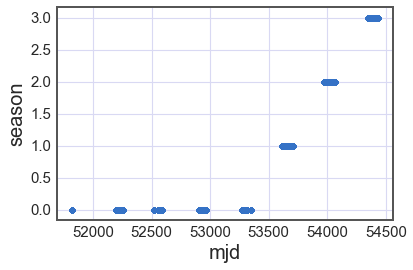

In [140]:
%matplotlib inline
# plot illustration of how mjd's are grouped into seasons...
import matplotlib.pyplot as plt
# Generic plot settings...
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

fig,ax = plt.subplots()
ax.scatter( raw_data['mjd'].data, np.array(raw_data['season'].data).astype(int))
ax.set_xlabel('mjd')
ax.set_ylabel('season')
plt.savefig('test.png')

In [149]:
# At the moment, it is impossible to apply complicated 
# functions to groupby objects....
# Easier at this point to just convert AstroPy table 
# to Pandas,  and do it from here on in Pandas ...
# Bummer. 

# But thankfully it only takes a few seconds 
# even on mac,  on the full patch  file 
raw_data_df = raw_data.to_pandas()

# calculate seasonal averages 
grouped = raw_data_df.groupby(['objectId','season'])

In [142]:
#imp.reload(varF)

In [104]:
#seasonal_averages

In [150]:
# calculate averages within each season
# since these are aggregates within each
# season, call it by that name to make 
# all things easier... 

season_agg= grouped.apply(varF.computeVarMetrics, 
                                 flux_column='psfFluxJy',
                                 error_column = 'psfFluxErrJy',
                                 time_column = 'mjd', 
                                 calc_sigma_pdf = False, 
                                 verbose=False,
                                 seasonal_average = True)
#
# returns a pd.Series with the following columns :
#
# 'objectId', 'season', 'N', 'chi2DOF', 'chi2R', 'flagLtTenPts', 'maxMJD',
# 'meanMJD', 'meanSN', 'minMJD', 'psfFluxMean', 'psfFluxMeanErr',
# 'psfFluxMedian', 'psfFluxMedianErr', 'psfFluxSigG', 'psfFluxSkew',
# 'psfFluxStDev'

In [133]:
#seasonal_averages.columns

In [151]:
# Calculate S/N : first using mean, and then median, and in each case if they
# are below 2,  replace by faintMean, faintMedian, faintRMS 

# read in the lookup interpolation table, 
# which makes it very fast thanks to the 
# smoothness of functions used  
table_address = 'flat_prior_const_counts_lookup.csv'
lookup = Table.read(table_address)


# 1.5  calculate faint quantities for all rows  where S/N < 2 
for avg in ['Mean', 'Median']:
    
    # temporary aliases to make it easier 
    S = season_agg['psfFlux'+avg].values
    N = season_agg['psfFlux'+avg+'Err'].values
    SN = S/N
    mask_SN = SN < 2 
    # make a new column storing that mask : 
    # True if SN < 2 , otherwise False 
    season_agg['flagFaint'+avg] = mask_SN
    print('There are %d seasons of %d that have %s-based  S/N < 2' %(np.sum(mask_SN),\
        len(mask_SN), avg))

    # interpolate at the xObs = SN  locations .... 
    faint_SN = SN[mask_SN]
    xMean =  np.interp(faint_SN,  lookup['xObs'].data, lookup['xMean'].data)
    xMed =  np.interp(faint_SN,   lookup['xObs'].data, lookup['xMedian'].data)
    xSigma =  np.interp(faint_SN, lookup['xObs'].data, lookup['xSigma'].data)
    xRMS = np.interp(faint_SN,    lookup['xObs'].data, lookup['xRMS'].data)
    
    # need to multiply by error to find flux 
    faintMean = xMean * N[mask_SN]
    faintRMS = xRMS * N[mask_SN]

    # Not sure if need to save these values for anything ... 
    # can always do it later,
    # but for now, replace the 
    # Signal  by faintMean , 
    # and Noise by faintRMS 
    season_agg['psfFlux'+avg][mask_SN] = faintMean
    season_agg['psfFlux'+avg+'Err'][mask_SN] = faintRMS

There are 2652 seasons of 5377 that have Mean-based  S/N < 2
There are 2812 seasons of 5377 that have Median-based  S/N < 2


In [178]:
#season_agg

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


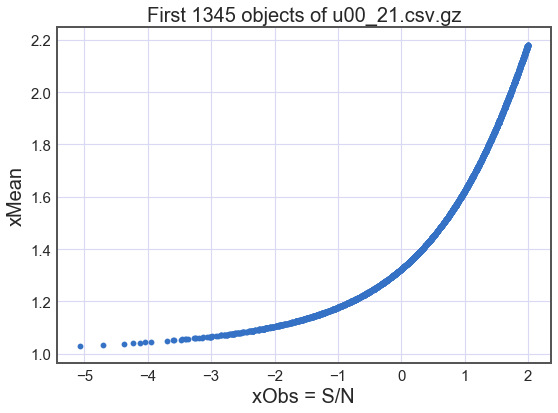

In [153]:
# Just to prove that everything works just fine ... 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(SN[mask_SN], faintMean/ N[mask_SN])
ax.set_xlabel('xObs = S/N')
ax.set_ylabel('xMean')
ax.set_title('First '+str(len(np.unique(raw_data['objectId']))) + \
             ' objects of u00_21.csv.gz')
plt.savefig('test_seasonally_binned_faint_pipeline1.png', bbox_inches='tight')

In [147]:
#seasonal_averages.index.levels[0]

In [156]:
# Calculate seasonal magnitudes 
# add in quadrature 0.003 mag to 
# those magErrs which are < 0.003 mag
# and update fluxErrs for the same 
# measurements using the fact that 
# for small errors, (<0.2 mag or so), 
# they are the same as fractional
# error in flux. So, given flux and fluxErr, 
# we redefine error to be
# fluxErrNew  = sqrt[ fluxErr^2 + (0.003*flux)^2 ]

for avg in ['Mean', 'Median'] : 
    fCol = 'psfFlux'+avg
    fErrCol = 'psfFlux'+avg+'Err'
    mCol = 'psf'+avg
    mErrCol = 'psf'+avg+'Err' 

    season_agg[mCol]= \
        procP.flux2ab(season_agg[fCol], unit='Jy')    
    season_agg[mErrCol] = \
        procP.flux2absigma(season_agg[fCol], season_agg[fErrCol])    

    # Wherever the error in magnitudes is smaller than the minimum value, 
    # add that minimum value
    # How many seasons have Mean Err < min_err ? 
    e_min = 0.003
    mask_err = season_agg[mErrCol].values < e_min
    print('Number of seasons with error < %.3f is %d'%(e_min,np.sum(mask_err)))

    # add to magnitude errors min_err for those very small ones....
    e_old = season_agg[mErrCol].values[mask_err]
    e_new = np.sqrt(e_min**2.0 + e_old**2.0 )

    # replace the originals
    season_agg[mErrCol].values[mask_err] = e_new

    # old flux error for these few seasons where 
    # magnitude error < 0.003  
    f_err_old =  season_agg[fErrCol].values[mask_err]
    f = season_agg[fCol].values[mask_err]

    # new flux error 
    f_err_new =  np.sqrt(f_err_old**2.0 + (e_min * f)**2.0)

    # replace the originals
    season_agg[fErrCol].values[mask_err] = f_err_new

Number of seasons with error < 0.003 is 6


In [164]:
season_agg

N   chi2DOF     chi2R  flagLtTenPts  \
objectId           season                                           
216172782516437336 0.0     13.0  2.449688  1.541985           NaN   
                   1.0     20.0  1.528823  0.869733           NaN   
                   2.0     20.0  1.319656  0.908277           NaN   
                   3.0     15.0  1.690726  0.727644           NaN   
216172782516437339 0.0     14.0  1.951810  1.110862           NaN   
                   1.0     18.0  0.947346  0.694827           NaN   
                   2.0     21.0  1.568071  0.866963           NaN   
                   3.0     17.0  1.060968  1.179825           NaN   
216172782516437345 0.0     13.0  1.601129  0.878055           NaN   
                   1.0     17.0  1.758758  1.593516           NaN   
                   2.0     20.0  1.211866  1.118920           NaN   
                   3.0     14.0  0.429513  0.695226           NaN   
216172782516437346 0.0     13.0  1.139076  0.673577           NaN   
                   1.0     19.0  1.403904  1.355180           NaN   
                   2.0     22.0  2.486800  1.814027           NaN   
                   3.0     17.0  1.365768  1.531222           NaN   
216172782516437358 0.0     13.0  1.380370  0.948803           NaN   
                   1.0     19.0  1.620069  0.856380           NaN   
                   2.0     23.0  1.002658  0.837702           NaN   
                   3.0     14.0  2.913868  1.244366           NaN   
216172782516437360 0.0     13.0  1.883825  1.275621           NaN   
                   1.0     19.0  1.476584  1.046214           NaN   
                   2.0     22.0  1.170688  1.168180           NaN   
                   3.0     17.0  2.119408  1.526392           NaN   
216172782516437362 0.0     16.0  2.013883  1.659733           NaN   
                   1.0     19.0  2.174719  1.619180           NaN   
                   2.0     21.0  1.728910  1.144189           NaN   
                   3.0     15.0  0.662391  0.907893           NaN   
216172782516437371 0.0     14.0  0.913104  0.926447           NaN   
                   1.0     17.0  1.487726  1.243959           NaN   
...                         ...       ...       ...           ...   
216172783590182833 2.0     29.0  1.496784  1.076326           NaN   
                   3.0     22.0  2.841216  1.413986           NaN   
216172783590182867 0.0     34.0  1.283393  0.978385           NaN   
                   1.0     34.0  2.905543  1.066362           NaN   
                   2.0     44.0  1.570488  1.194865           NaN   
                   3.0     24.0  2.484732  1.516277           NaN   
216172783590182886 0.0     35.0  0.940876  0.931832           NaN   
                   1.0     31.0  1.497892  1.446349           NaN   
                   2.0     40.0  2.239643  0.735827           NaN   
                   3.0     31.0  2.222604  1.094109           NaN   
216172783590182898 0.0     36.0  3.041976  1.986236           NaN   
                   1.0     30.0  1.404324  1.234287           NaN   
                   2.0     40.0  2.755931  1.962939           NaN   
                   3.0     29.0  1.191485  0.879783           NaN   
216172783590182905 0.0     39.0  1.297093  1.125484           NaN   
                   1.0     30.0  1.594374  1.480655           NaN   
                   2.0     40.0  1.322055  1.449963           NaN   
                   3.0     29.0  1.575027  0.965682           NaN   
216172783590182910 0.0     34.0  2.452884  1.436273           NaN   
                   1.0     37.0  2.203426  1.505037           NaN   
                   2.0     43.0  1.450375  1.464888           NaN   
                   3.0     31.0  1.124865  1.155207           NaN   
216172783590182920 0.0     36.0  1.659880  1.567765           NaN   
                   1.0     30.0  2.049353  1.286653           NaN   
                   2.0     42.0  1.854686  1.372438           NaN   
                   3.0     3

In [174]:
# need to change the multindex to columns, to be able to aggregate again...
# https://stackoverflow.com/questions/20110170/turn-pandas-multi-index-into-column 
season_agg.reset_index(inplace=True)  

#### Save the seasonal averages HERE ! 
path = DirOut+ 'S_'+name
season_agg.to_csv(path)

In [169]:
season_agg[:10]

,objectId,season,N,chi2DOF,chi2R,flagLtTenPts,maxMJD,meanMJD,meanSN,minMJD,...,psfFluxMeanErr,psfFluxMedian,psfFluxMedianErr,psfFluxSigG,psfFluxSkew,psfFluxStDev,flagFaintMean,flagFaintMedian,psfMedian,psfMedianErr
0,216172782516437336,0.0,13.0,2.449688,1.541985,NaN,53352.112576,52767.698502,1.279859,51819.354709,...,2.180433e-07,1.148548e-06,2.732768e-07,1.126948e-06,0.0,1.180163e-06,False,False,23.749627,0.258332
1,216172782516437336,1.0,20.0,1.528823,0.869733,NaN,53705.212024,53666.262256,1.115632,53622.320880,...,2.723698e-07,1.439498e-06,3.413649e-07,1.380788e-06,0.0,1.466114e-06,False,False,23.504472,0.257473
2,216172782516437336,2.0,20.0,1.319656,0.908277,NaN,54068.218192,54027.121269,0.973769,53975.296819,...,2.808414e-07,1.328418e-06,3.519825e-07,1.139126e-06,0.0,1.357195e-06,False,False,23.591663,0.287681
3,216172782516437336,3.0,15.0,1.690726,0.727644,NaN,54422.234976,54395.610309,1.216188,54357.275736,...,2.848709e-07,1.087355e-06,3.570327e-07,1.478026e-06,0.0,1.358368e-06,False,False,23.809071,0.356501
4,216172782516437339,0.0,14.0,1.951810,1.110862,NaN,53352.112576,52777.883569,0.329167,51819.354709,...,1.640995e-07,3.355410e-07,2.047141e-07,7.040100e-07,0.0,1.023135e-06,True,True,25.085636,0.662409
5,216172782516437339,1.0,18.0,0.947346,0.694827,NaN,53705.212024,53665.430719,-0.120047,53622.320880,...,1.546251e-07,3.511089e-07,2.453291e-07,1.103142e-06,0.0,1.112617e-06,True,True,25.036395,0.758633
6,216172782516437339,2.0,21.0,1.568071,0.866963,NaN,54068.218192,54026.988690,0.177131,53975.296819,...,1.641359e-07,1.792930e-07,1.514410e-07,1.294525e-06,0.0,1.359208e-06,True,True,25.766092,0.917074
7,216172782516437339,3.0,17.0,1.060968,1.179825,NaN,54422.234976,54397.095459,0.335943,54357.275736,...,2.360296e-07,5.573493e-07,2.947225e-07,1.437758e-06,0.0,1.092188e-06,True,True,24.534681,0.574130
8,216172782516437345,0.0,13.0,1.601129,0.878055,NaN,53352.112576,52767.698374,-0.136317,51819.354709,...,9.539201e-08,1.607724e-07,1.316038e-07,7.797275e-07,0.0,8.966255e-07,True,True,25.884471,0.888753
9,216172782516437345,1.0,17.0,1.758758,1.593516,NaN,53705.212024,53666.029743,-0.228740,53622.320880,...,1.094802e-07,1.488873e-07,1.322911e-07,2.436486e-06,0.0,1.459337e-06,True,True,25.967856,0.964711


In [170]:
#

In [171]:
# 3a) Aggregate by objectId
grouped = season_agg.groupby('objectId')

# calculate stats using seasonal averages... 
# do it only using Mean... 
# next time around can also do that using Median, and 
# hstack the two ... 

# the problem here is that we have 
# mean-based and median-based seasonal averages,
# and then we calculate averages of that 
# so in a way we'd have mean of mean, median of mean,
# mean of median,  median of median,
# depending on what we choose to represent
# seasonal fluxes below as 
# flux_column  and error_column
varMetricsSeasons  = grouped.apply(varF.computeVarMetrics, 
                                 flux_column='psfFluxMean',
                                 error_column = 'psfFluxMeanErr',
                                 time_column = 'meanMJD', 
                                 calc_sigma_pdf = False, 
                                 verbose=False,
                                 seasonal_average = False)

In [172]:
varMetricsSeasons

,N,chi2DOF,chi2R,flagLtTenPts,meanMJD,meanSN,psfFluxMean,psfFluxMeanErr,psfFluxMedian,psfFluxMedianErr,psfFluxSigG,psfFluxSkew,psfFluxStDev,rangeMJD
objectId,,,,,,,,,,,,,,
216172782516437336,4.0,0.580119,0.538673,1.0,53714.173084,4.719552,1.213620e-06,1.296246e-07,1.305269e-06,1.624603e-07,1.347847e-07,0.0,1.675619e-07,1627.911807
216172782516437339,4.0,0.326598,0.390734,1.0,53716.849609,1.538377,2.568917e-07,8.637738e-08,2.453067e-07,1.082580e-07,7.507801e-08,0.0,8.118315e-08,1619.211891
216172782516437345,4.0,1.308271,1.288682,1.0,53714.138182,1.404558,1.606570e-07,6.571457e-08,2.463204e-07,8.236099e-08,1.864313e-07,0.0,9.659905e-08,1628.004988
216172782516437346,4.0,2.810588,1.203361,1.0,53714.679038,2.722430,5.712245e-07,1.103480e-07,5.816207e-07,1.383007e-07,2.742155e-07,0.0,3.127708e-07,1629.397085
216172782516437358,4.0,1.347483,0.799555,1.0,53713.564329,3.000960,7.118996e-07,1.229080e-07,8.349675e-07,1.540423e-07,1.892870e-07,0.0,2.385696e-07,1628.004920
216172782516437360,4.0,0.138401,0.209594,1.0,53714.679038,2.133334,5.039137e-07,1.188815e-07,4.955966e-07,1.489959e-07,5.348534e-08,0.0,7.559592e-08,1629.397085
216172782516437362,4.0,2.754228,1.048542,1.0,53709.896305,3.317759,7.333105e-07,1.130893e-07,8.874816e-07,1.417364e-07,2.279526e-07,0.0,3.206201e-07,1642.801644
216172782516437371,4.0,1.001131,0.516878,1.0,53717.129617,1.551768,2.410790e-07,8.522732e-08,2.419627e-07,1.068166e-07,1.145324e-07,0.0,1.242370e-07,1616.039247
216172782516437379,4.0,0.368229,0.447805,1.0,53714.522507,2.329856,5.716123e-07,1.243322e-07,5.742793e-07,1.558274e-07,1.154001e-07,0.0,1.282922e-07,1628.004988


In [179]:
# need to rename the columns to reflect the fact that we used seasonal Mean-based averages,
# as opposed to Median-based averages 
# Or just use mean-based averages for now 

# calculate magnitudes for full light curve aggregates based on seasonal averages 
varMetricsSeasons['psfMean'] = procP.flux2ab(
    varMetricsSeasons['psfFluxMean'], 
                                                unit='Jy')
varMetricsSeasons['psfMeanErr'] = procP.flux2absigma(varMetricsSeasons['psfFluxMean'], 
                                                     varMetricsSeasons['psfFluxMeanErr'])    

In [176]:
#### Save the full LC Metrics based on averaged seasons .... 
path = DirOut+ 'VarS_'+name
varMetricsSeasons.to_csv(path)

In [177]:
DirOut

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/varMetrics/'

In [180]:
print('Number of seasons with error < %.3f is %d'%
      (e_min,np.sum(mask_err)))

Number of seasons with error < 0.003 is 6


In [181]:
season_bounds = [str(year)+'-08-01 00:00:00.000' for year in 
                 np.arange(2005,2009)]

In [182]:
print('Calculating the  LC statistics \
      using S/N > 2  points only ...')

Calculating the  LC statistics       using S/N > 2  points only ...
